In [2]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [3]:
# Load data
df = pd.read_excel('data/Monthly Mastersheet.xlsx')

# Ensure date is datetime and set index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df.columns = df.columns.str.strip() #strip spaces in names
print(df.head())


             Bitcoin   Tether  Litecoin       XRP  Ethereum  Dogecoin  \
Month                                                                   
2017-09-01 -1.398923 -3.82830  -1.02849 -0.898590 -1.320943 -1.405018   
2017-10-01 -1.339539 -3.73861  -0.77151 -1.145490 -0.837982 -0.464897   
2017-11-01 -1.622995 -4.01951  -1.44830 -1.192080 -1.837874 -1.371050   
2017-12-01 -1.267670 -2.55687  -1.11575 -1.254630 -1.310402 -0.702095   
2018-01-01 -0.892511 -2.75193  -0.24164  0.038975 -0.811280 -0.334438   

            Cardano  USD Coin    VIX   MOVE  LFPR      CPI     r      M1  \
Month                                                                      
2017-09-01      NaN       NaN  10.59  52.88  63.1  246.819  1.15  3535.6   
2017-10-01      NaN       NaN   9.51  51.15  62.7  246.663  1.15  3615.0   
2017-11-01      NaN       NaN  10.18  46.83  62.7  246.669  1.16  3587.6   
2017-12-01      NaN       NaN  11.28  46.60  62.7  246.524  1.30  3630.5   
2018-01-01      NaN       NaN  1

# VAR testing
## 1. Data Preparation
##### 1.1 make sure macros are endogenous- Each variable is explained by its own past values and the past values of all other variables in the system, no variable is assumed to be strictly independent.

##### 1.2 Same Integration order: test for stationarity using ADF

In [4]:
from statsmodels.tsa.stattools import adfuller

for col in df.columns:
    result = adfuller(df[col].dropna())
    print(f'{col}: p-value = {result[1]}')

Bitcoin: p-value = 1.0920519383748658e-07
Tether: p-value = 0.8239483673421706
Litecoin: p-value = 6.988828950914855e-08
XRP: p-value = 0.15677767022854167
Ethereum: p-value = 0.19481860779486204
Dogecoin: p-value = 0.00021364853735330477
Cardano: p-value = 0.36553877495692955
USD Coin: p-value = 0.010444507366033444
VIX: p-value = 0.0005140917362464705
MOVE: p-value = 0.39943677654417753
LFPR: p-value = 0.08227483714715461
CPI: p-value = 0.9044645691224062
r: p-value = 0.2221536107412167
M1: p-value = 0.6682267419637112
GDP: p-value = 0.6825705492402224
IM: p-value = 0.9431792986923209
EX: p-value = 0.8691521189557727
CC: p-value = 0.6282641357619623
CC Monthly % Change: p-value = 2.125797825164221e-07
Bitcoin Price: p-value = 0.9720747605868902


p>0.05, Tether, XRP, Ethereum, Cardano, MOVE, LFPR, CPI, r, M1, GDP, IM, EX, CC need to be diffed

In [5]:
def check_stationarity(series):
    result = adfuller(series.dropna())
    p_value = result[1]
    print(f"ADF test for {series.name}: p-value = {p_value:.4f}")

list=['Tether', 'XRP', 'Ethereum', 'Cardano', 'MOVE', 'LFPR', 'CPI', 'r', 'M1', 'GDP', 'IM', 'EX', 'CC','Bitcoin Price']
for l in list:
    check_stationarity(df[l].diff())  # Expect p < 0.05

ADF test for Tether: p-value = 0.0000
ADF test for XRP: p-value = 0.0000
ADF test for Ethereum: p-value = 0.0000
ADF test for Cardano: p-value = 0.0000
ADF test for MOVE: p-value = 0.0000
ADF test for LFPR: p-value = 0.0000
ADF test for CPI: p-value = 0.5877
ADF test for r: p-value = 0.1568
ADF test for M1: p-value = 0.0000
ADF test for GDP: p-value = 0.0000
ADF test for IM: p-value = 0.0000
ADF test for EX: p-value = 0.0000
ADF test for CC: p-value = 0.0000
ADF test for Bitcoin Price: p-value = 0.0000


In [6]:
list=['CPI', 'r']
for l in list:
    check_stationarity((df[l].diff()).diff())

ADF test for CPI: p-value = 0.0000
ADF test for r: p-value = 0.0000


Stationarity order results:
Bitcoin: 0
Tether: 1
Litecoin: 0
XRP: 1
Ethereum: 1
Dogecoin: 0
Cardano: 1
USD Coin: 0
VIX: 0
MOVE: 1
LFPR: 1
CPI: 2
r: 2
M1: 1
GDP: 1
IM: 1
EX: 1
CC: 1
CC Monthly % Change: 0
Bitcoin price: 1

##### 1.3 run VAR using variables that are order 0, and differenced for those that are order 1

In [7]:
df['D1_Ethereum']=df['Ethereum'].diff()
df['D1_XRP']=df['XRP'].diff()
df['D1_Cardano']=df['Cardano'].diff()
df['D1_M1']=df['M1'].diff()
df['D1_LFPR']=df['LFPR'].diff()
df['D1_GDP']=df['GDP'].diff()
df['D1_EX']=df['EX'].diff()
df['D1_IM']=df['IM'].diff()


# var_columns = [
#     'Bitcoin', 'Litecoin', 'Dogecoin', 'VIX', 'CC Monthly % Change',
#     'D1_Ethereum', 'D1_XRP', 'D1_Cardano',
#     'D1_M1', 'D1_LFPR', 'D1_GDP', 'D1_EX', 'D1_IM'
# ]

var_columns = [
    'Bitcoin', 'VIX',
    'D1_M1', 'D1_LFPR', 'D1_GDP',
]

var_data = df[var_columns].dropna()


# 2. Fit VAR model

In [8]:
from statsmodels.tsa.api import VAR

model = VAR(var_data)
lag_order = model.select_order(12)
print(lag_order.summary())

results = model.fit(lag_order.aic)  # or lag_order.bic
print(results.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        26.78       26.94   4.286e+11       26.85
1        24.34       25.26   3.722e+10       24.71
2        23.56      25.24*   1.718e+10      24.23*
3        23.32       25.77   1.383e+10       24.30
4        23.17       26.39  1.238e+10*       24.45
5        23.23       27.22   1.420e+10       24.83
6        23.13       27.88   1.428e+10       25.03
7        23.05       28.57   1.547e+10       25.26
8        22.92       29.21   1.713e+10       25.44
9        22.87       29.92   2.230e+10       25.69
10       22.76       30.58   3.165e+10       25.89
11       22.13       30.72   3.240e+10       25.57
12      20.92*       30.27   2.520e+10       24.65
--------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 12, Jun

/Users/tianyishen/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


['Bitcoin', 'VIX', 'D1_M1', 'D1_LFPR', 'D1_GDP']


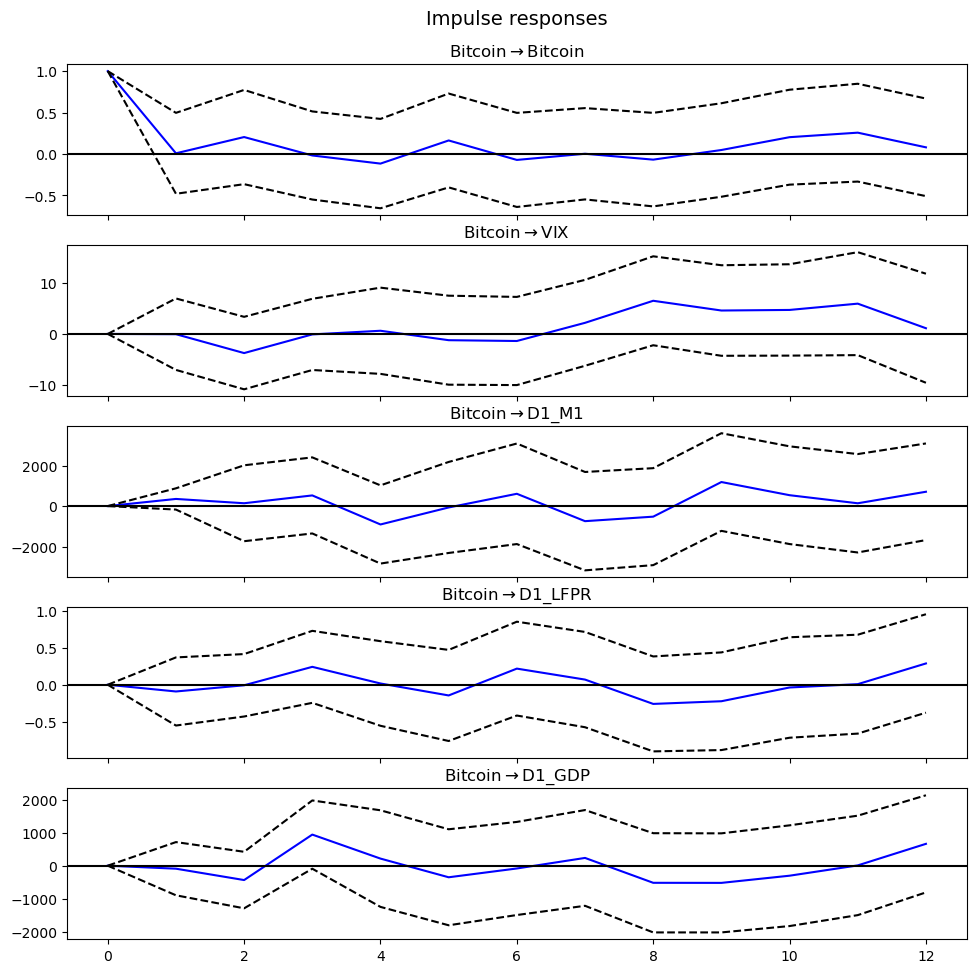

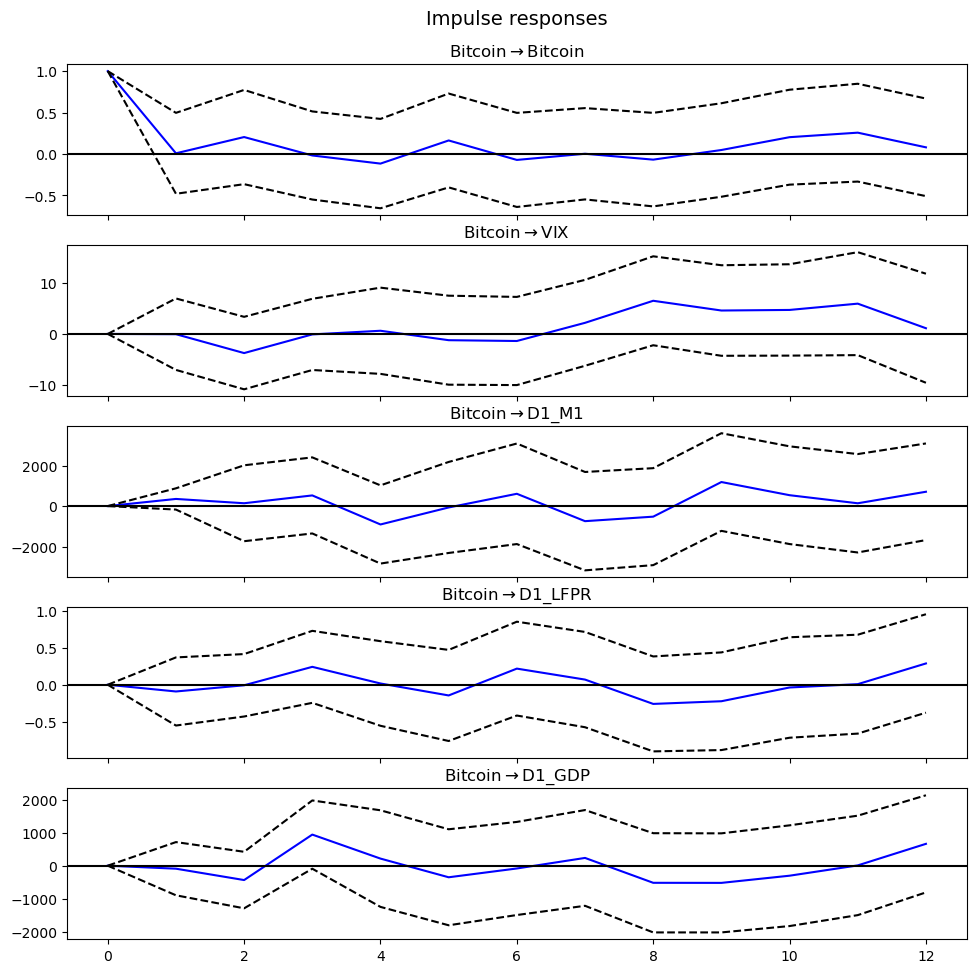

In [9]:
# Assuming 'model' is your fitted VAR model from statsmodels:
# For example: model = VAR(df_diff).fit(lag_order)
print(results.names)

irf = results.irf(12)  # IRF for 12 periods ahead

# Plot impulse response of macro variables to a shock in Bitcoin
irf.plot(impulse='Bitcoin')

Results: Bitcoin volatility shock has no significant impact on macros.

/Users/tianyishen/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


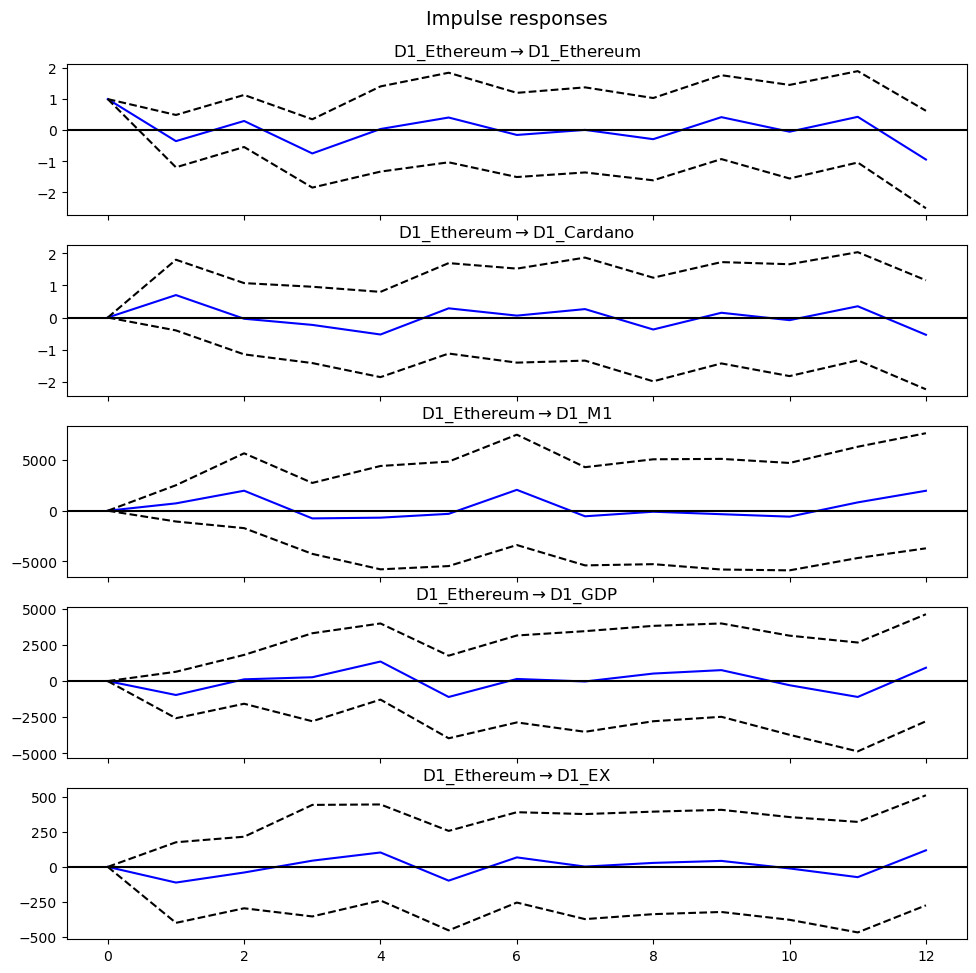

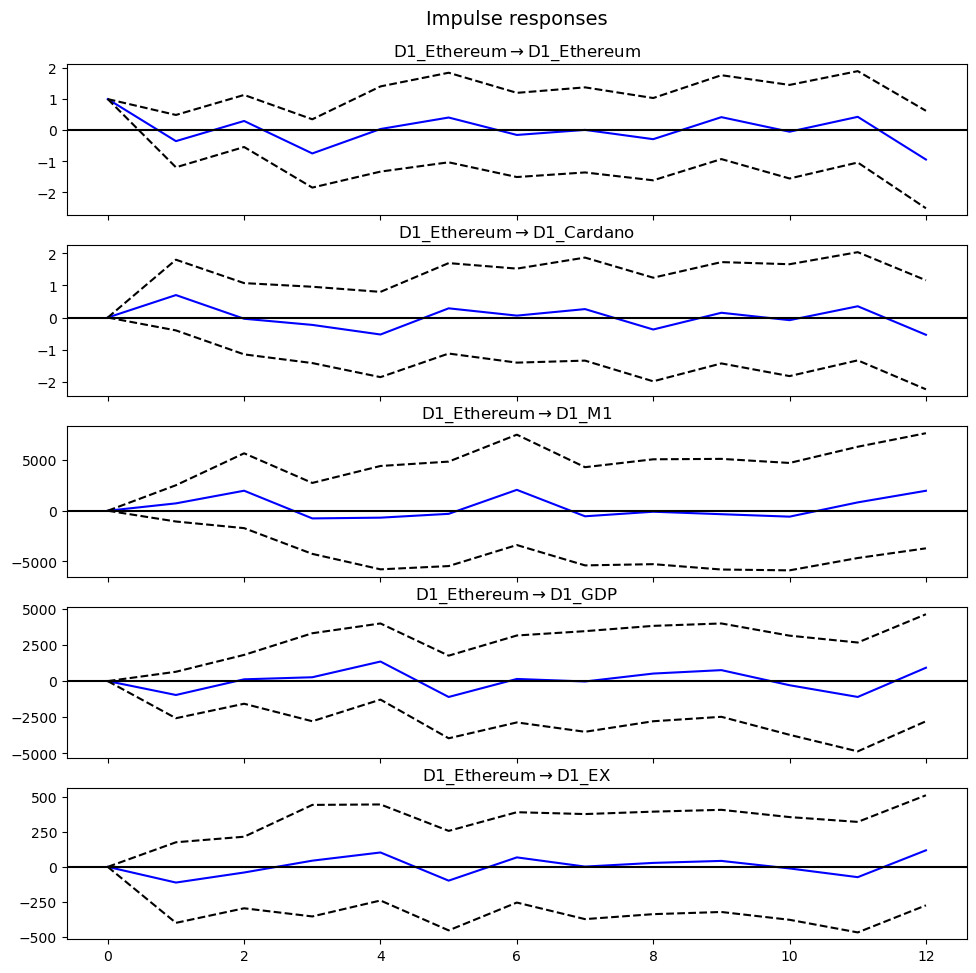

In [10]:
var_columns = [
    'D1_Ethereum','D1_Cardano',
    'D1_M1',  'D1_GDP', 'D1_EX',
]

var_data = df[var_columns].dropna()

model = VAR(var_data)
lag_order = model.select_order(12)
results = model.fit(lag_order.aic)

irf = results.irf(12)  # IRF for 12 periods ahead

# Plot impulse response of macro variables to a shock in Bitcoin
irf.plot(impulse='D1_Ethereum')

/Users/tianyishen/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


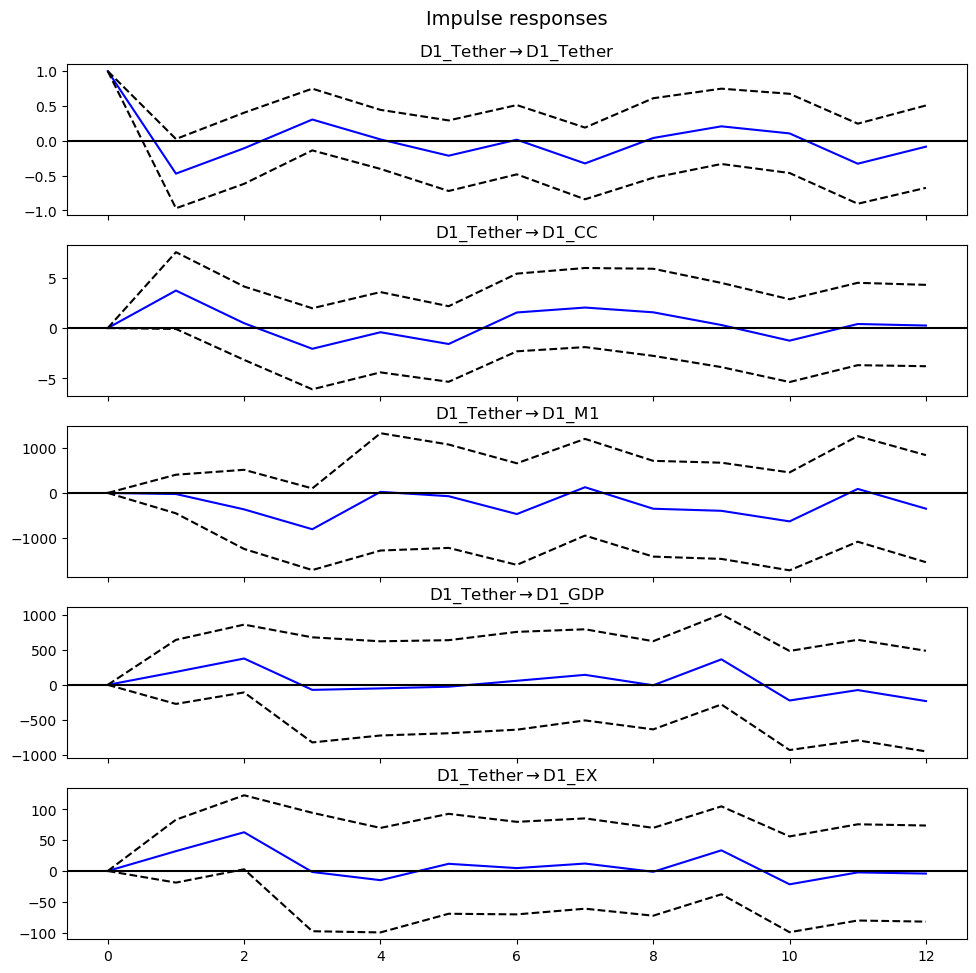

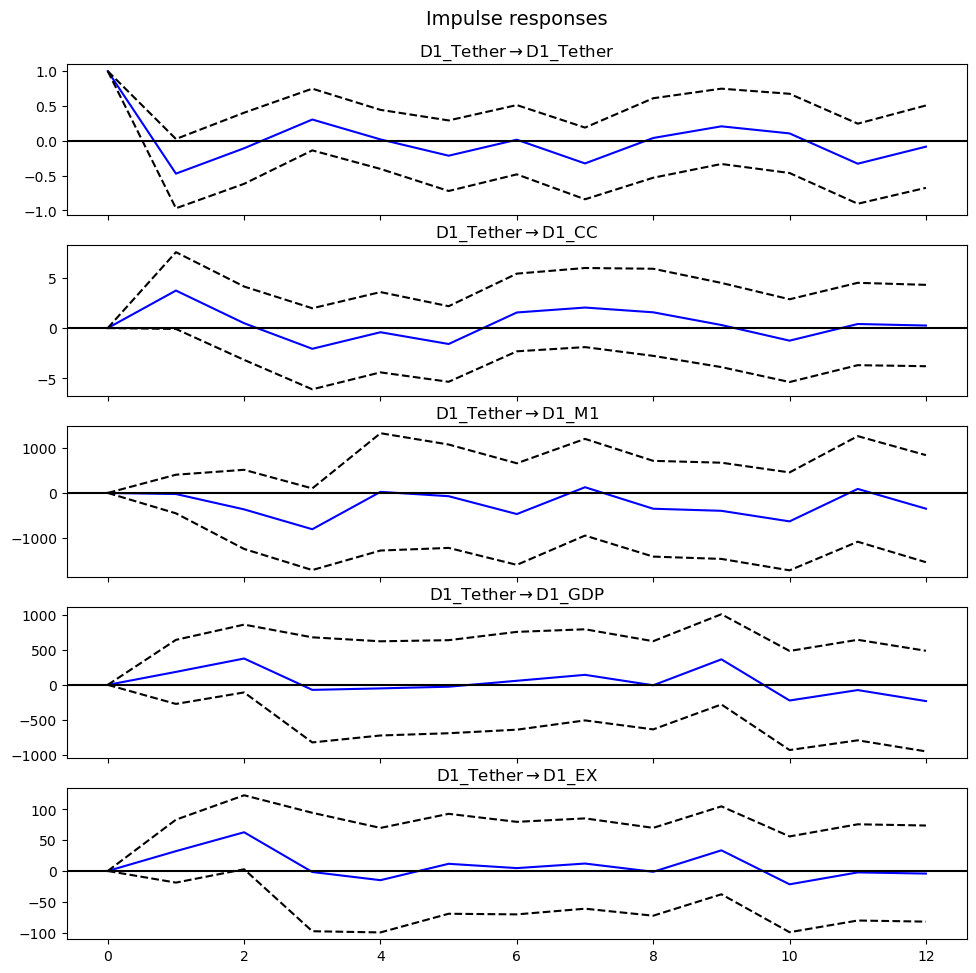

In [11]:
df['D1_Tether']=df['Tether'].diff()
df['D1_CC']=df['CC'].diff()

var_columns = [
    'D1_Tether','D1_CC',
    'D1_M1',  'D1_GDP', 'D1_EX'
]

var_data = df[var_columns].dropna()

model = VAR(var_data)
lag_order = model.select_order(12)
results = model.fit(lag_order.aic)

irf = results.irf(12)  # IRF for 12 periods ahead

# Plot impulse response of macro variables to a shock in Bitcoin
irf.plot(impulse='D1_Tether')

# 4. Trying for price data
short term, very limited effect

/Users/tianyishen/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


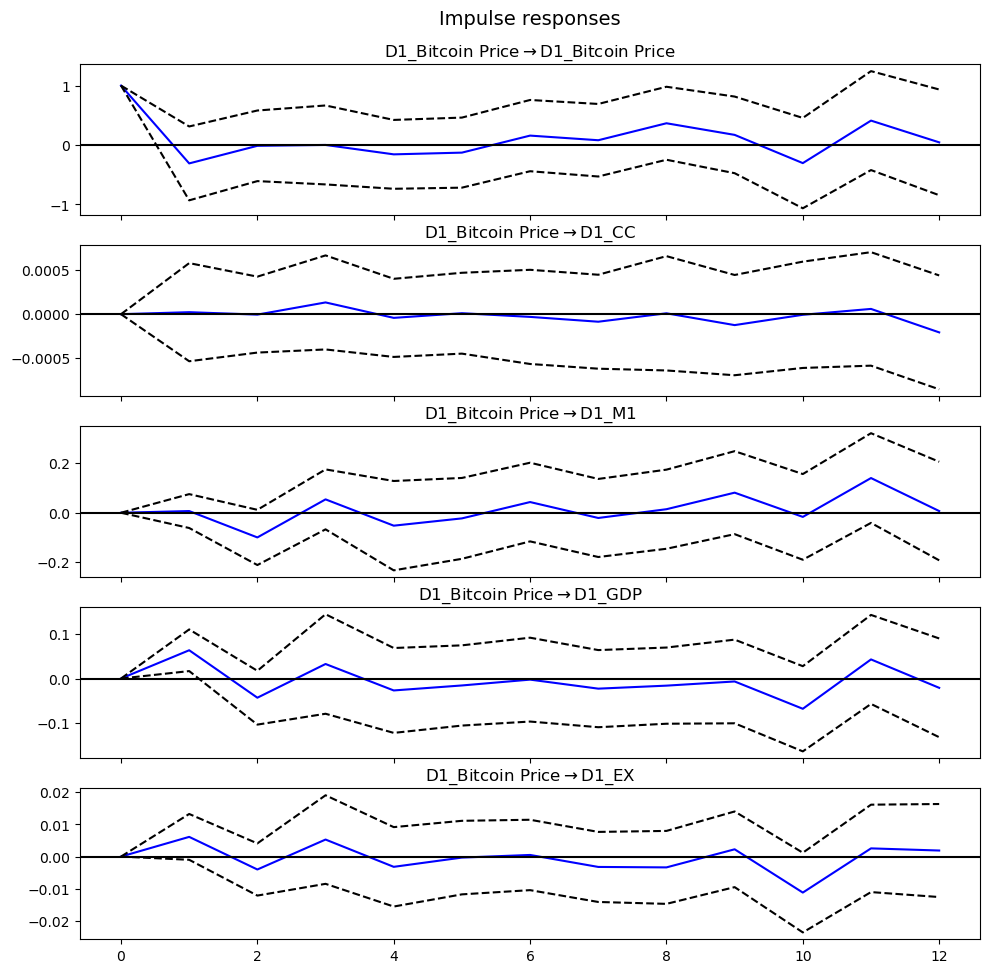

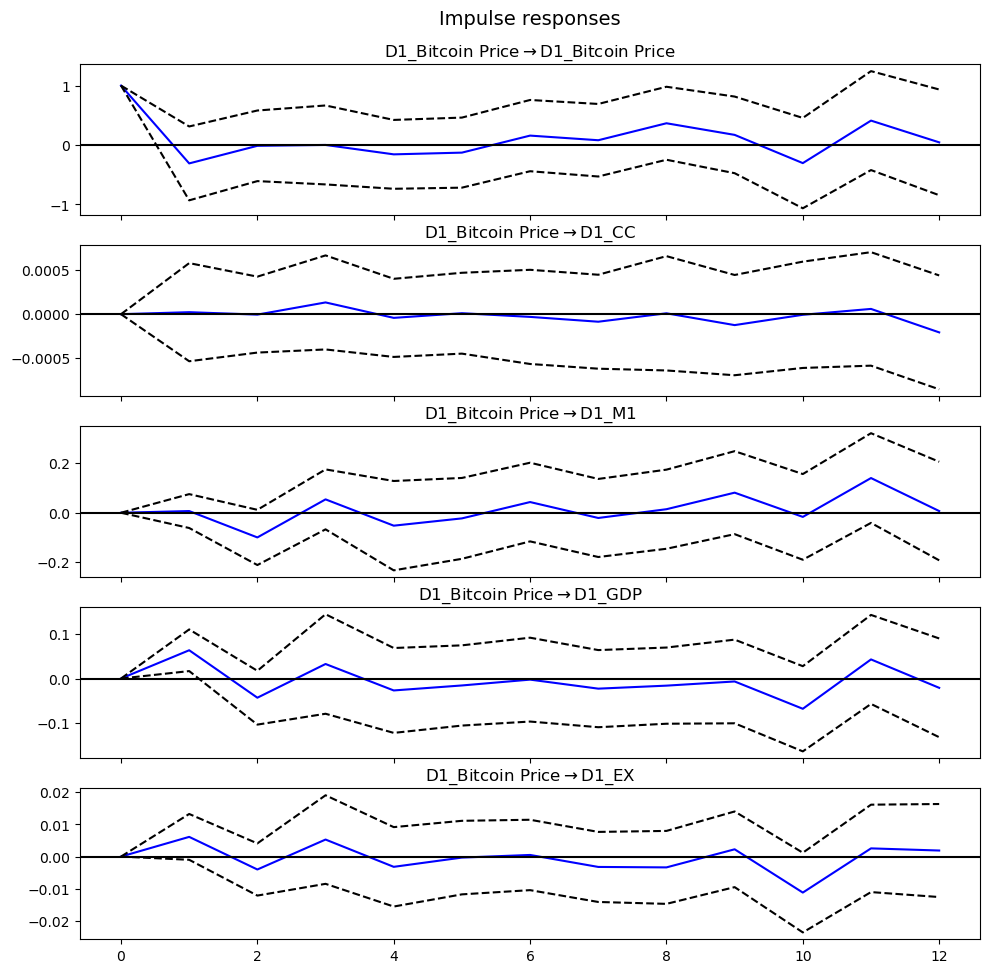

In [13]:
df['D1_Bitcoin Price']=df['Bitcoin Price'].diff()

var_columns = [
    'D1_Bitcoin Price','D1_CC',
    'D1_M1',  'D1_GDP', 'D1_EX'
]

var_data = df[var_columns].dropna()

model = VAR(var_data)
lag_order = model.select_order(12)
results = model.fit(lag_order.aic)

irf = results.irf(12)  # IRF for 12 periods ahead

# Plot impulse response of macro variables to a shock in Bitcoin
irf.plot(impulse='D1_Bitcoin Price')

/Users/tianyishen/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


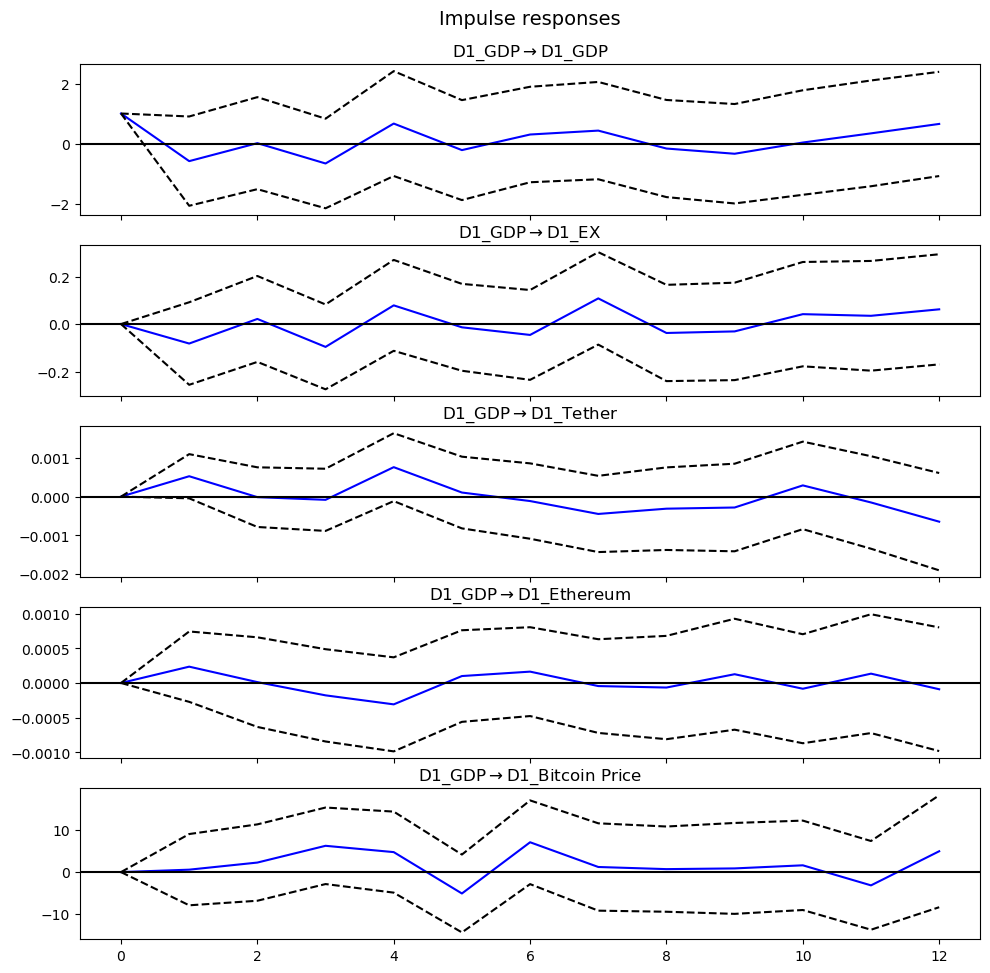

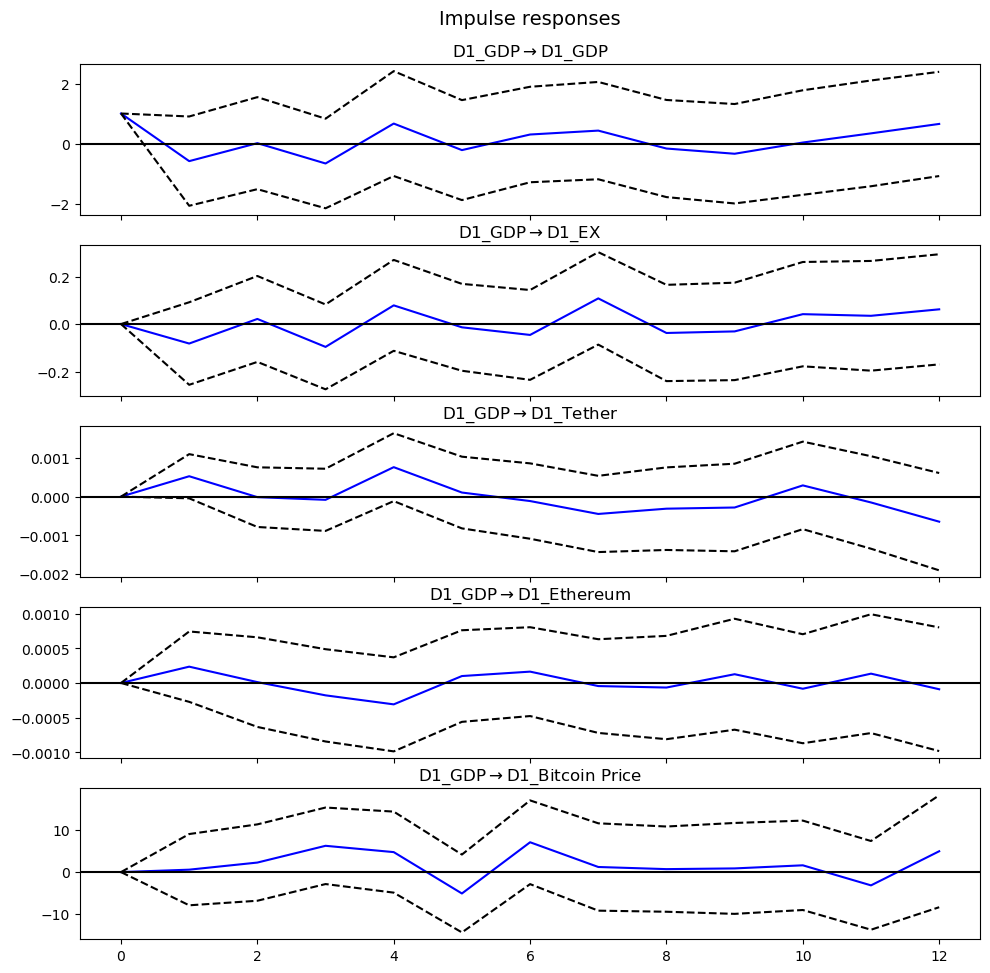

In [18]:
var_columns = [
    'D1_GDP','D1_EX',
    'D1_Tether',  'D1_Ethereum', 'D1_Bitcoin Price'
]

var_data = df[var_columns].dropna()

model = VAR(var_data)
lag_order = model.select_order(12)
results = model.fit(lag_order.aic)

irf = results.irf(12)  # IRF for 12 periods ahead

# Plot impulse response of macro variables to a shock in Bitcoin
irf.plot(impulse='D1_GDP')